In [214]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [227]:
full_annotations = pd.read_csv("/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/data/raw/TCGA/nationwidechildrens.org_biospecimen_slide_gbm.txt",sep='\t')
sample = pd.read_csv("/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/results/TCGA/predict_sample_100.csv")
# clean up
del sample['Unnamed: 0']

sample['basename']=sample['filename'].apply(lambda x: x.replace(os.path.dirname(x),''))
#sample['svs_name']=sample['basename'].str.extract('(TCGA-\d\d-\d\d\d\d-\d\d[A-Z]-\d\d-[A-Z][A-Z]\d)', expand=True)
sample['svs_name']=sample['basename'].str.extract('(TCGA-[A-Za-z0-9_-]+-[A-Za-z0-9_-]+-\d\d[A-Z]-\d\d-[A-Z][A-Z][A-Za-z0-9_-])', expand=True)

In [228]:
sample

,VGG_label,Inception_label,Resnet_label,Densenet_label,filename,basename,svs_name
0,2,2,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
1,2,3,2,3,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
2,2,2,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
3,2,3,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
4,2,2,2,3,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
5,4,2,2,3,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
6,3,2,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
7,4,3,2,3,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
8,2,3,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1
9,2,3,2,2,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,/TCGA-19-5960-01A-01-BS1.9027d19c-bb31-4b20-aa...,TCGA-19-5960-01A-01-BS1


In [229]:
#random_rows = sample.sample(n=100)
#random_rows.to_csv('/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/results/TCGA/random_100rows_100samples.csv')
random_images = []
random_images_path = "/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/data/raw/TCGA/random_100/"
for file in os.listdir(random_images_path):
    if file.endswith(".jpg"):
        random_images.append(random_images_path+file)

In [230]:
annotations = full_annotations[['bcr_slide_barcode','percent_tumor_cells','percent_necrosis']]
annotations = annotations.iloc[1:]
annotations = annotations[annotations['bcr_slide_barcode'].isin(sample['svs_name'].unique())]
tumor_df=annotations[['bcr_slide_barcode','percent_tumor_cells']]
necrosis_df=annotations[['bcr_slide_barcode','percent_necrosis']]

In [231]:
for model in ['VGG','Inception','Resnet','Densenet']:
    label=model+'_label'
    print(label)
    pred = sample.groupby(['svs_name',label])[label].count()
    for svs in sample['svs_name'].unique():
        # 2 is cellular tumor; 3 is necrosis 
        if 2 in pred[svs]:
            tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=100*pred[svs][2]/sum(pred[svs])    
        else:
            tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=0
        if 3 in pred[svs]:
            necrosis_df.loc[necrosis_df['bcr_slide_barcode']==svs,model]=100*pred[svs][3]/sum(pred[svs])    
        else:
            necrosis_df.loc[necrosis_df['bcr_slide_barcode']==svs,model]=0

VGG_label
Inception_label
Resnet_label
Densenet_label


In [232]:
#tumor_df['percent_tumor_cells']=tumor_df['percent_tumor_cells'].astype(float,errors = 'ignore')
tumor_df['percent_tumor_cells']=pd.to_numeric(tumor_df['percent_tumor_cells'],errors = 'coerce')
necrosis_df['percent_necrosis']=pd.to_numeric(necrosis_df['percent_necrosis'],errors = 'coerce')
#tumor_df

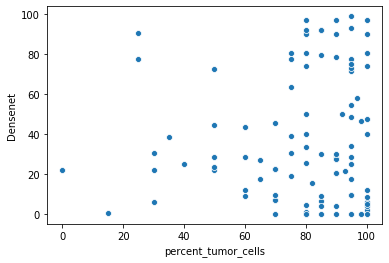

In [233]:
ax = sns.scatterplot(x="percent_tumor_cells", y="Densenet", data=tumor_df)

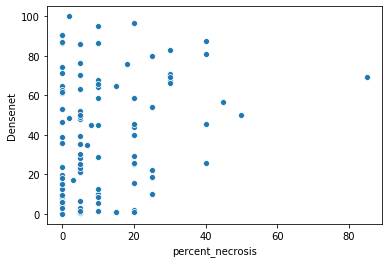

In [234]:
ax = sns.scatterplot(x="percent_necrosis", y="Densenet", data=necrosis_df)

In [259]:
#ax.scatter(necrosis_df['percent_necrosis'], necrosis_df['VGG'])
#ax.scatter(necrosis_df['percent_necrosis'], necrosis_df['Inception'], color='r')
#plt.show()


In [235]:
necrosis_df_melted=pd.melt(necrosis_df, id_vars=['bcr_slide_barcode','percent_necrosis'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_percent')
tumor_df_melted=pd.melt(tumor_df, id_vars=['bcr_slide_barcode','percent_tumor_cells'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_percent')
#necrosis_df_melted

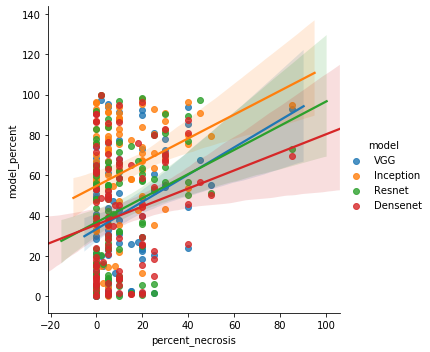

In [236]:
ax = sns.lmplot(x="percent_necrosis", y="model_percent", hue="model", data=necrosis_df_melted)

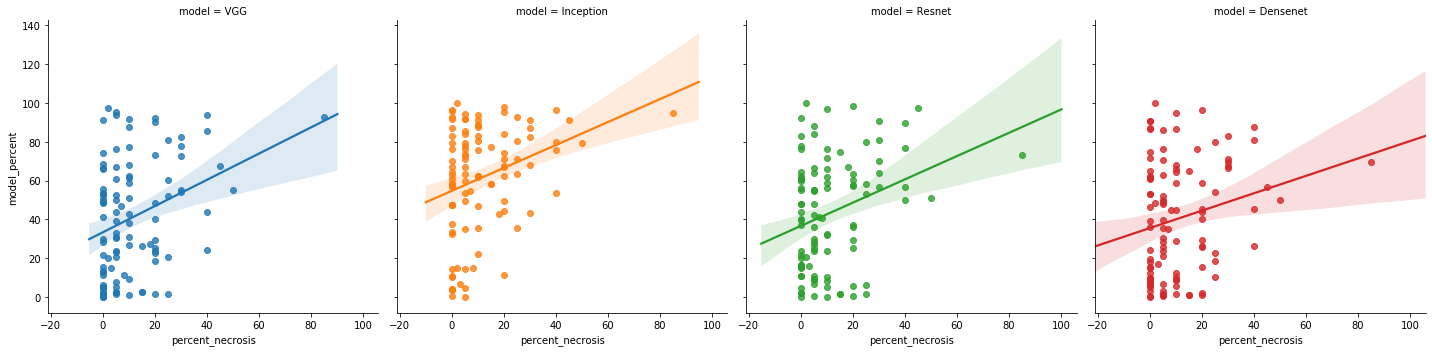

In [237]:
ax = sns.lmplot(x="percent_necrosis", y="model_percent", hue="model", col='model', data=necrosis_df_melted)

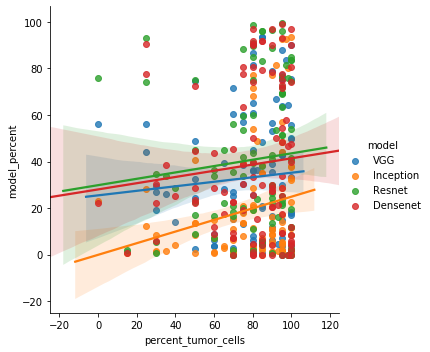

In [238]:
ax = sns.lmplot(x="percent_tumor_cells", y="model_percent", hue="model", data=tumor_df_melted)

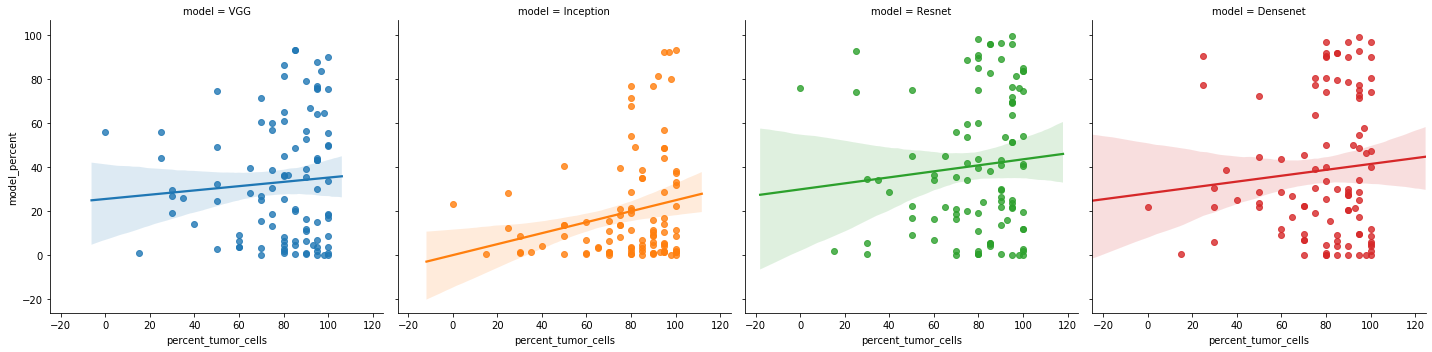

In [239]:
ax = sns.lmplot(x="percent_tumor_cells", y="model_percent", hue="model", col ='model', data=tumor_df_melted)

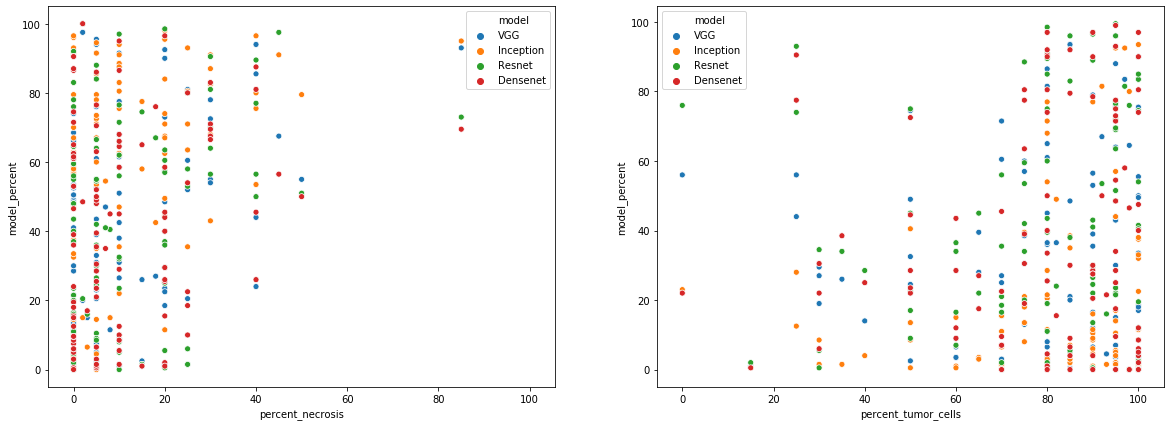

In [240]:
f, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
sns.scatterplot(x="percent_necrosis", y="model_percent", hue="model", data=necrosis_df_melted, ax=axes[0])
sns.scatterplot(x="percent_tumor_cells", y="model_percent", hue="model", data=tumor_df_melted, ax=axes[1])

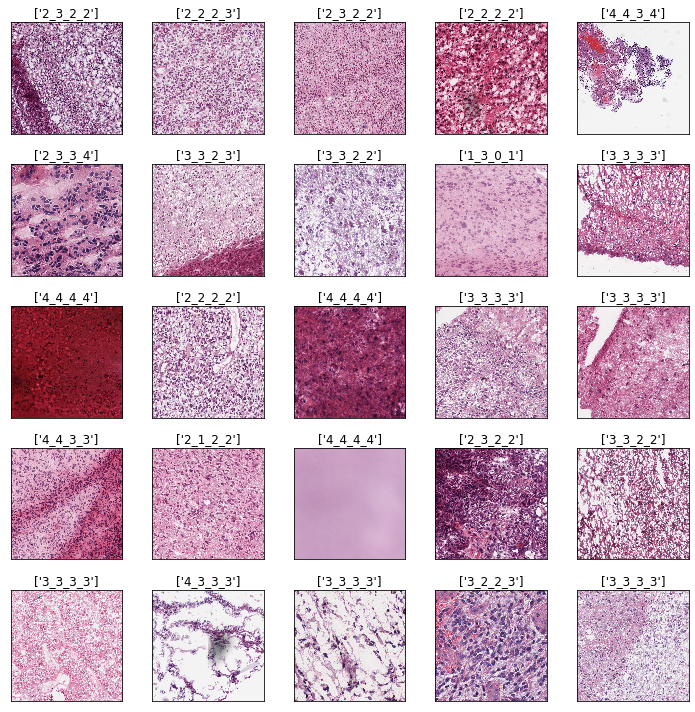

In [241]:
x_lim = 5
y_lim = 5
f, axes = plt.subplots(x_lim, y_lim, figsize=(10, 10))
imgs = random.sample(random_images,k=x_lim*y_lim)
for i in range(x_lim):
    for j in range(y_lim):
        img_base = '/'+os.path.basename(imgs[j+x_lim*i])
        sub_df = sample[sample['basename']==img_base]        
        title=sub_df['VGG_label'].astype(str) +'_'+sub_df['Inception_label'].astype(str)+'_'+sub_df['Resnet_label'].astype(str)+'_'+sub_df['Densenet_label'].astype(str)
        img = plt.imread(imgs[j+x_lim*i])
        axes[i,j].imshow(img)
        axes[i,j].set_title(title.values)
        axes[i,j].xaxis.set_visible(False)
        axes[i,j].yaxis.set_visible(False)

plt.tight_layout()
#plt.axis('off')
#plt.tick_params(axis='both', which='both', right=False, left=False, top=False, bottom=False)

# 0-leading edge, 1-infiltrating tumor, 2-cellular tumor, 3-necrosis, 4-background.

In [529]:
## This section does not use the single-label predictions from each model. Instead, it uses the probability predictions for each category
# plot mean value of predictions for necrosis 
full_annotations = pd.read_csv("/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/data/raw/TCGA/nationwidechildrens.org_biospecimen_slide_gbm.txt",sep='\t')
predictions = pd.read_csv("/Users/chenyuelu/Desktop/things/MBI/research/YuLab/GBM/results/TCGA/predict_sample_100_fullpred.csv")
# clean up
del predictions['Unnamed: 0']

predictions['basename']=predictions['filename'].apply(lambda x: x.replace(os.path.dirname(x),''))
#sample['svs_name']=sample['basename'].str.extract('(TCGA-\d\d-\d\d\d\d-\d\d[A-Z]-\d\d-[A-Z][A-Z]\d)', expand=True)
predictions['svs_name']=predictions['basename'].str.extract('(TCGA-[A-Za-z0-9_-]+-[A-Za-z0-9_-]+-\d\d[A-Z]-\d\d-[A-Z][A-Z][A-Za-z0-9_-])', expand=True)

In [530]:
predictions

,0,1,2,3,4,filename,model,basename,svs_name
0,0.000679,0.005447,0.890796,0.027535,0.075542,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
1,0.000241,0.011007,0.871868,0.054244,0.062639,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
2,0.000002,0.005467,0.285563,0.015088,0.693880,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
3,0.002048,0.455849,0.270787,0.019181,0.252135,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
4,0.000237,0.017105,0.971747,0.001008,0.009903,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
5,0.000830,0.000784,0.159059,0.137441,0.701885,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
6,0.001747,0.406429,0.508039,0.000147,0.083638,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
7,0.000650,0.256559,0.636944,0.000511,0.105336,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
8,0.000468,0.126381,0.573482,0.034842,0.264828,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1
9,0.000021,0.141167,0.301522,0.025045,0.532245,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1


In [531]:
annotations = full_annotations[['bcr_slide_barcode','percent_tumor_cells','percent_necrosis']]
annotations = annotations.iloc[1:]
annotations = annotations[annotations['bcr_slide_barcode'].isin(predictions['svs_name'].unique())]
tumor_df=annotations[['bcr_slide_barcode','percent_tumor_cells']]
necrosis_df=annotations[['bcr_slide_barcode','percent_necrosis']]

In [329]:
# annotations

In [532]:
for model in predictions['model'].unique():
    label=model+'_label'
#     print(label)
    # 2 is cellular tumor; 3 is necrosis 
    tumor_pred = predictions.groupby(['svs_name','model'])['2'].mean()
    necrosis_pred = predictions.groupby(['svs_name','model'])['3'].mean()    
    for svs in predictions['svs_name'].unique():
#         print(tumor_pred[svs][model])
        # 2 is cellular tumor; 3 is necrosis 
        tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=tumor_pred[svs][model]   
        necrosis_df.loc[necrosis_df['bcr_slide_barcode']==svs,model]=necrosis_pred[svs][model]   

In [533]:
tumor_df['percent_tumor_cells']=pd.to_numeric(tumor_df['percent_tumor_cells'],errors = 'coerce')
necrosis_df['percent_necrosis']=pd.to_numeric(necrosis_df['percent_necrosis'],errors = 'coerce')
necrosis_df_melted=pd.melt(necrosis_df, id_vars=['bcr_slide_barcode','percent_necrosis'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_mean_prob')
tumor_df_melted=pd.melt(tumor_df, id_vars=['bcr_slide_barcode','percent_tumor_cells'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_mean_prob')

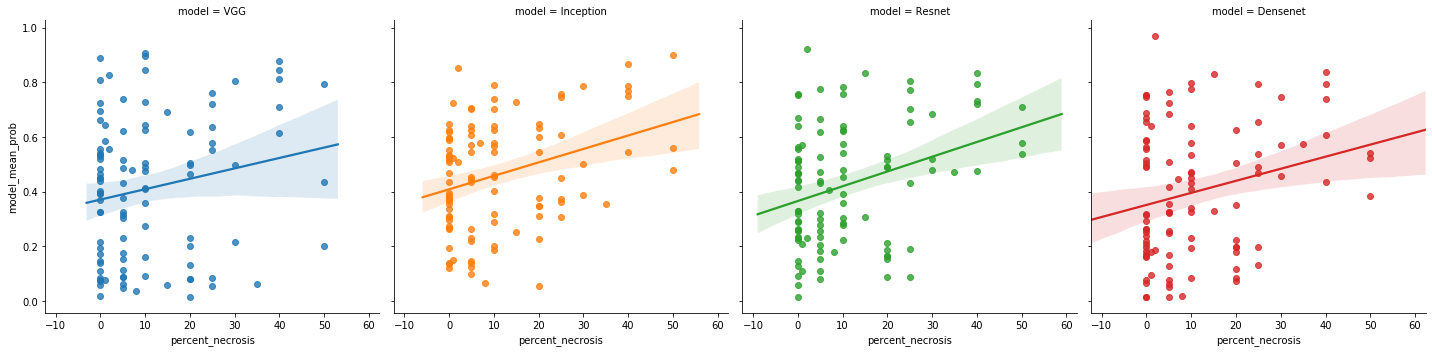

In [534]:
ax = sns.lmplot(x="percent_necrosis", y="model_mean_prob",hue ='model', col='model',data=necrosis_df_melted)

In [536]:
for model in predictions['model'].unique():
    print(model, pearsonr(necrosis_df_melted[necrosis_df_melted['model']==model]['model_mean_prob'],necrosis_df_melted[necrosis_df_melted['model']==model]['percent_necrosis']))

VGG (0.19374649899518587, 0.05103824829577764)
Inception (0.3205416796680547, 0.0010215169113181512)
Resnet (0.32453744324879125, 0.0008752612680716345)
Densenet (0.24308019836800804, 0.013825086611125111)


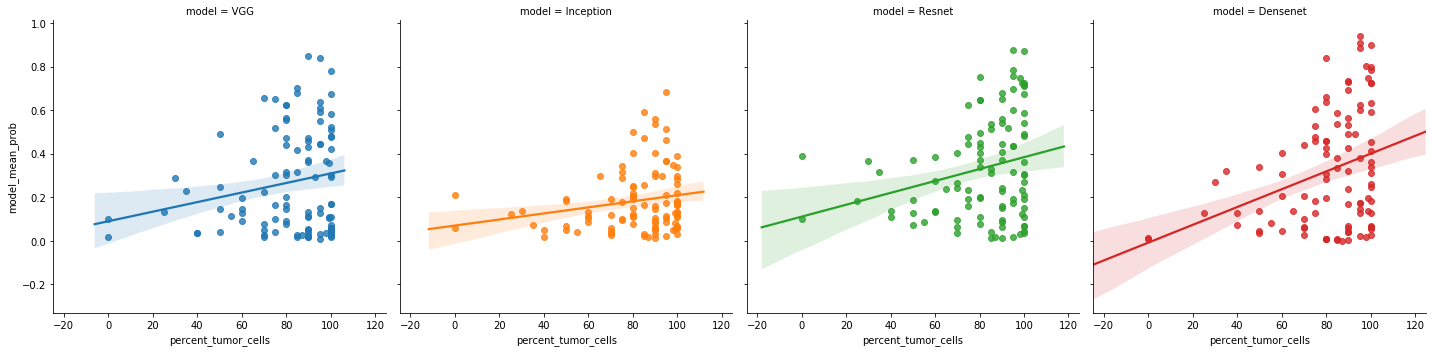

In [537]:
ax = sns.lmplot(x="percent_tumor_cells", y="model_mean_prob",hue ='model', col='model',data=tumor_df_melted)

In [539]:
for model in predictions['model'].unique():
    print(model, pearsonr(tumor_df_melted[tumor_df_melted['model']==model]['model_mean_prob'],tumor_df_melted[tumor_df_melted['model']==model]['percent_tumor_cells']))

VGG (0.19871794102097307, 0.04525962053018987)
Inception (0.20097231495209136, 0.04282421399451383)
Resnet (0.24558889507092457, 0.012846875517006496)
Densenet (0.3201260593577626, 0.0010379434001943244)


In [540]:
# plot the unique label predictions using the same 100 samples to see difference in approach
predictions['pred'] = predictions[['0','1','2','3','4']].idxmax(axis=1)

In [543]:
tumor_df=annotations[['bcr_slide_barcode','percent_tumor_cells']]
necrosis_df=annotations[['bcr_slide_barcode','percent_necrosis']]
tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=100*pred[svs][2]/sum(pred[svs])    

In [544]:
for model in predictions['model'].unique():
    pred = predictions.groupby(['svs_name','model','pred'])['pred'].count()
    for svs in predictions['svs_name'].unique():
        # 2 is cellular tumor; 3 is necrosis 
        if '2' in pred[svs][model]:
            tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=100*pred[svs][model]['2']/sum(pred[svs][model])  
        else:
            tumor_df.loc[tumor_df['bcr_slide_barcode']==svs,model]=0
        if '3' in pred[svs][model]:
            necrosis_df.loc[necrosis_df['bcr_slide_barcode']==svs,model]=100*pred[svs][model]['3']/sum(pred[svs][model])    
        else:
            necrosis_df.loc[necrosis_df['bcr_slide_barcode']==svs,model]=0

In [554]:
tumor_df['percent_tumor_cells']=pd.to_numeric(tumor_df['percent_tumor_cells'],errors = 'coerce')
necrosis_df['percent_necrosis']=pd.to_numeric(necrosis_df['percent_necrosis'],errors = 'coerce')

necrosis_df_melted=pd.melt(necrosis_df, id_vars=['bcr_slide_barcode','percent_necrosis'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_percent')
tumor_df_melted=pd.melt(tumor_df, id_vars=['bcr_slide_barcode','percent_tumor_cells'], value_vars=['VGG', 'Inception','Resnet','Densenet'],var_name='model',value_name='model_percent')

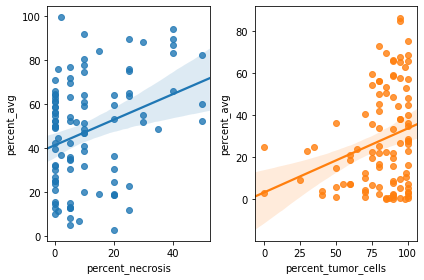

In [565]:
necrosis_df['percent_avg'] = (necrosis_df['VGG']+necrosis_df['Inception']+necrosis_df['Resnet']+necrosis_df['Densenet'])/4
tumor_df['percent_avg'] = (tumor_df['VGG']+tumor_df['Inception']+tumor_df['Resnet']+tumor_df['Densenet'])/4
fig, ax =plt.subplots(1,2)
sns.regplot(x="percent_necrosis",y='percent_avg', data=necrosis_df,ax=ax[0],fit_reg=True)
sns.regplot(x="percent_tumor_cells",y='percent_avg', data=tumor_df,ax=ax[1],fit_reg=True)
plt.tight_layout()

In [566]:
print(pearsonr(necrosis_df['percent_avg'],necrosis_df['percent_necrosis']))
print(pearsonr(tumor_df['percent_avg'],tumor_df['percent_tumor_cells']))


(0.31717729694138397, 0.0011615745703826095)
(0.2681554210843626, 0.006431013521017805)


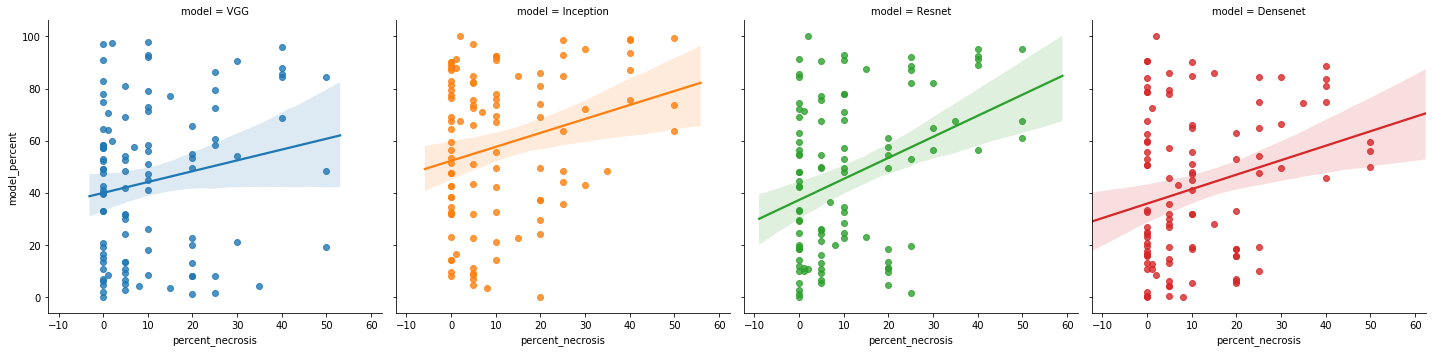

In [555]:
ax = sns.lmplot(x="percent_necrosis", y="model_percent", hue="model", col='model', data=necrosis_df_melted)

In [548]:
for model in predictions['model'].unique():
    print(model, pearsonr(necrosis_df_melted[necrosis_df_melted['model']==model]['model_percent'],necrosis_df_melted[necrosis_df_melted['model']==model]['percent_necrosis']))

VGG (0.18602040082136717, 0.06121580280690384)
Inception (0.2467966882157291, 0.012397828584721129)
Resnet (0.3611957448903703, 0.00019172858192948705)
Densenet (0.2574752232715595, 0.008987557829605877)


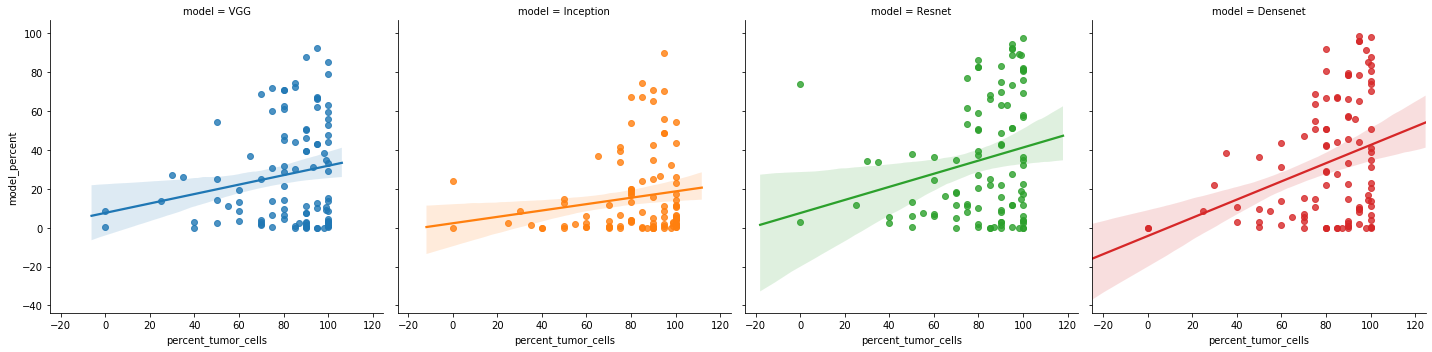

In [549]:
ax = sns.lmplot(x="percent_tumor_cells", y="model_percent", hue="model", col='model', data=tumor_df_melted)

In [550]:
for model in predictions['model'].unique():
    print(model, pearsonr(tumor_df_melted[tumor_df_melted['model']==model]['model_percent'],tumor_df_melted[tumor_df_melted['model']==model]['percent_tumor_cells']))

VGG (0.19325116528248848, 0.05164593035818991)
Inception (0.1624726742187289, 0.1027784800121735)
Resnet (0.22775668120770554, 0.021322427842586696)
Densenet (0.3150664656775551, 0.0012581482376618873)


In [425]:
# see correlation between models and ensemble the output 
predictions

,0,1,2,3,4,filename,model,basename,svs_name,pred
0,0.000679,0.005447,0.890796,0.027535,0.075542,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
1,0.000241,0.011007,0.871868,0.054244,0.062639,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
2,0.000002,0.005467,0.285563,0.015088,0.693880,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,4
3,0.002048,0.455849,0.270787,0.019181,0.252135,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,1
4,0.000237,0.017105,0.971747,0.001008,0.009903,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
5,0.000830,0.000784,0.159059,0.137441,0.701885,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,4
6,0.001747,0.406429,0.508039,0.000147,0.083638,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
7,0.000650,0.256559,0.636944,0.000511,0.105336,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
8,0.000468,0.126381,0.573482,0.034842,0.264828,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,2
9,0.000021,0.141167,0.301522,0.025045,0.532245,/mnt/data2/datasets/tcgaGBM/tissueImages/1000d...,VGG,/TCGA-02-0113-01A-01-TS1.d214ab63-9826-43c8-aa...,TCGA-02-0113-01A-01-TS1,4


In [460]:
ensemble_predictions = predictions.groupby(['svs_name'])['0','1','2','3','4'].mean()

In [491]:
ensemble_df = pd.merge(ensemble_predictions,annotations,left_on='svs_name', right_on='bcr_slide_barcode')

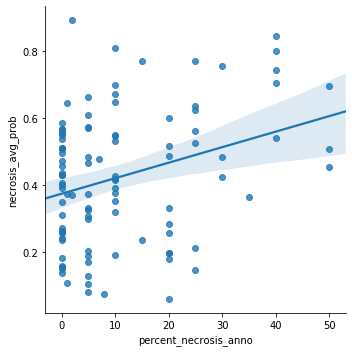

In [492]:
ensemble_df['percent_necrosis']=pd.to_numeric(ensemble_df['percent_necrosis'],errors = 'coerce')
ensemble_df['percent_tumor_cells']=pd.to_numeric(ensemble_df['percent_tumor_cells'],errors = 'coerce')
ensemble_df.columns=['leading_edge_avg_prob','infiltrating_tumor_avg_prob','cellular_tumor_avg_prob','necrosis_avg_prob','background_avg_prob','svs_image','percent_tumor_anno','percent_necrosis_anno']
ax = sns.lmplot(x="percent_necrosis_anno",y='necrosis_avg_prob', data=ensemble_df)

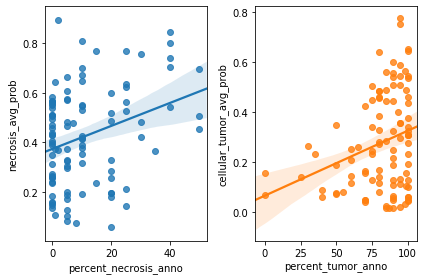

In [551]:
fig, ax =plt.subplots(1,2)
sns.regplot(x="percent_necrosis_anno",y='necrosis_avg_prob', data=ensemble_df,ax=ax[0],fit_reg=True)
sns.regplot(x="percent_tumor_anno",y='cellular_tumor_avg_prob', data=ensemble_df,ax=ax[1],fit_reg=True)
plt.tight_layout()

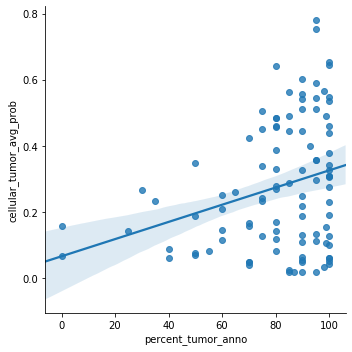

In [552]:
ax = sns.lmplot(x="percent_tumor_anno",y='cellular_tumor_avg_prob', data=ensemble_df)

In [553]:
from scipy.stats import pearsonr
necrosis_cor, necrosis_p = pearsonr(ensemble_df['percent_necrosis_anno'],ensemble_df['necrosis_avg_prob'])
tumor_cor, tumor_p = pearsonr(ensemble_df['percent_tumor_anno'],ensemble_df['cellular_tumor_avg_prob'])

In [517]:
necrosis_cor, necrosis_p

(0.3096148744827498, 0.0015422680527105953)

In [522]:
tumor_cor, tumor_p

(0.27918593768493405, 0.004488459983229809)

In [580]:
random.randint(1,18)

18